# How to optimize controls with nonlinear dependences
**Incorporate nonlinear Hamiltonian dependences on control signals**

Boulder Opal exposes a highly-flexible [optimization engine](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/run_optimization) for general-purpose gradient-based optimization.  It can be directly applied to model-based control optimization for arbitrary-dimensional quantum systems.  In some cases the relationship between a control parameter and Hamiltonian term is nonlinear, presenting a major challenge for standard optimization routines.  

In this notebook we demonstrate how to simply incorporate arbitrary nonlinear relationships between control parameters such that it is possible to directly perform an optimization which returns proper lab-frame control signals to generate and output.
To learn the basics about control optimization, you can follow our [robust optimization tutorial](https://docs.q-ctrl.com/boulder-opal/tutorials/design-robust-single-qubit-gates-using-computational-graphs).

## Summary workflow
### 1. Define nonlinearity in computational graph
The flexible Boulder Opal optimization engine expresses all optimization problems as data flow graphs, which describe how optimization variables (variables that can be tuned by the optimizer) are transformed into the cost function (the objective that the optimizer attempts to minimize).  Typical costs involve minimization of an infidelity metric captured using the `graph.infidelity_pwc` graph operation.

Expressing non-linear dependence between control parameters and Hamiltonians is achieved by performing standard arithmetical operations on the control parameters prior to constructing signals which are employed in the graph. For instance:
```python
signal = graph.real_optimizable_pwc_signal(
    segment_count=segment_count,
    minimum=signal_min,
    maximum=signal_max,
    duration=duration,
    name="signal"
    )
signal_squared = signal ** 2 / signal_max
signal_squared.name = "signal_squared"
```

### 2. Run graph-based optimization

With the graph object created, an optimization can be run using the `boulderopal.run_optimization` function. The cost, the outputs, and the graph must be provided. The function returns the results of the optimization. Note that this example code block uses naming that should be replaced with the naming used in your graph.

## Example: Optimized controls with a nonlinear relationship to a single-qubit Hamiltonian

We present an example showing how a system with non-linear dependence between controls and Hamiltonian may be optimized. We consider an artificial single-qubit system represented by the following Hamiltonian:
$$
H(t) = \alpha_1(t)\sigma_x + \frac{\alpha_1(t)^2}{\alpha_{\text{max}}}\sigma_y + \alpha_2(t)\sigma_z  ,
$$
where $\alpha_1(t)$ and $\alpha_2(t)$ are real time-dependent pulses, and we note the non-linear dependence of the Hamiltonian on $\alpha_1(t)$. 

While here we have chosen a simple artificial non-linearity for the sake of convenience and brevity, the approach we demonstrate extends trivially to far more complex, physically-relevant situations.

Expressing non-linear dependence between control parameters and Hamiltonians is achieved by performing standard arithmetical operations on the control parameters prior to constructing signals. In this case the operations are very simple—we simply square and re-scale the parameters describing the $\alpha_1(t)$ values—but in general any combination of supported primitive operations may be used.

In [1]:
import numpy as np
import qctrlvisualizer as qv
import boulderopal as bo

Your task (action_id="1828726") has started.
Your task (action_id="1828726") has completed.

Optimized cost:	5.467e-13


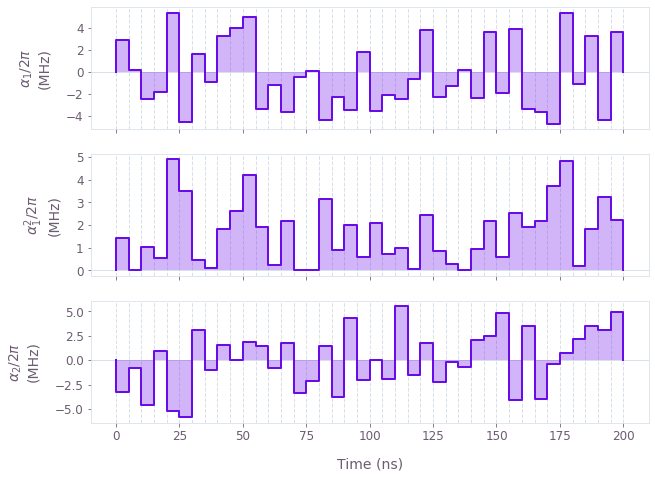

In [2]:
# Define physical constraints
alpha_max = 2 * np.pi * 6e6  # Hz
segment_count = 40
duration = 200e-9  # s

graph = bo.Graph()

# Create the alpha_1(t) signal
alpha_1 = graph.real_optimizable_pwc_signal(
    segment_count=segment_count,
    minimum=-alpha_max,
    maximum=alpha_max,
    duration=duration,
    name="alpha_1",
)

# Apply a non-linear transformation to create the alpha_1_squared(t) signal
alpha_1_squared = alpha_1**2 / alpha_max
alpha_1_squared.name = "alpha_1_squared"

# Create the alpha_2(t) signal
alpha_2 = graph.real_optimizable_pwc_signal(
    segment_count=segment_count,
    minimum=-alpha_max,
    maximum=alpha_max,
    duration=duration,
    name="alpha_2",
)

# Create Hamiltonian terms
x_term = alpha_1 * graph.pauli_matrix("X")
y_term = alpha_1_squared * graph.pauli_matrix("Y")
z_term = alpha_2 * graph.pauli_matrix("Z")

target_operator = graph.target(operator=graph.pauli_matrix("X"))

# Create infidelity
infidelity = graph.infidelity_pwc(
    hamiltonian=x_term + y_term + z_term, target=target_operator, name="infidelity"
)

# Run the optimization
optimization_result = bo.run_optimization(
    graph=graph,
    cost_node_name="infidelity",
    output_node_names=["alpha_1", "alpha_1_squared", "alpha_2"],
    optimization_count=4,
)

print(f"\nOptimized cost:\t{optimization_result['cost']:.3e}")

# Plot the optimized controls
qv.plot_controls(
    {
        r"$\alpha_1$": optimization_result["output"]["alpha_1"],
        r"$\alpha_1^2$": optimization_result["output"]["alpha_1_squared"],
        r"$\alpha_2$": optimization_result["output"]["alpha_2"],
    }
)